In [3]:
import os
import pandas as pd
import praw
import time
import pickle

from dotenv import load_dotenv
from plotnine import *
from praw.models import MoreComments

load_dotenv('.env')
username, client_id, client_secret, pw = (
    os.environ['username'],
    os.environ['client_id'],
    os.environ['client_secret'],
    os.environ['pw'])

reddit = praw.Reddit(client_id=client_id, \
                     client_secret=client_secret, \
                     user_agent='jwhendy-scraper', \
                     username=username, \
                     password=pw)

In [4]:
sub_limit = 150
n_top = 50
n_old = 1000

subs = ['askreddit', 'dataisbeautiful', 'funny', 'adviceanimals', 'friendsafari', 
        'pics', 'wtf', 'gaming', 'videos', 'teenagers', 'todayilearned', 'worldnews', 'nba', 'soccer', 'hockey',
        'debatereligion', 'askscience', 'announcements', 'aww', 'music', 'movies', 'news', 'showerthoughts', 'science', 'iama', 'food',
        'jokes', 'explainlikeimfive', 'gifs', 'books', 'lifeprotips', 'art', 'blog', 'earthporn', 'mildlyinteresting', 'diy', 'sports',
        'nottheonion', 'space', 'gadgets', 'television', 'documentaries', 'photoshopbattles', 'listentothis', 'upliftingnews',
        'tifu', 'internetisbeautiful', 'history', 'philosophy', 'futurology', 'oldschoolcool', 'writingprompts', 'nosleep', 
        'personalfinance', 'creepy', 'twoxchromosomes', 'memes']

def get_post_info(post, sub_name):
    info = {
        'sub': sub_name,
        'post_id': post.id,
        'title': post.title,
        'comments': post.num_comments,
        'score': post.score,
        'created_utc': post.created_utc
    }

    return info

def get_comment_info(comment, sort):    
    info = {
        #'sub': comment.subreddit.title,
        'post_id': comment.submission.id,
        'comment_id': comment.id,
        'created_utc': comment.created_utc,
        'score': comment.score,
        'top_level': comment.parent_id.startswith('t3_'),
        'sort': sort}

    return info

def get_comments(post, sort, n):
    post.comment_sort = sort
    post.comment_limit = n
    #post.comments.replace_more(limit=0)
    
    return [get_comment_info(c, sort) for c in post.comments.list() if not isinstance(c, MoreComments)]


def save_cmnt_df(cmnt_list, sub_name, n, perc):
    df_cmnt = pd.DataFrame(cmnt_list)
    df = df_cmnt.merge(pd.DataFrame(post_list), on='post_id')
    df.columns = ['post_id', 'comment_id', 'comment_created_utc', 'comment_score', 'top_level',
                  'sort', 'sub', 'post_title', 'comments_n', 'post_score', 'post_created_utc']
    df = df.sort_values(['post_id', 'comment_created_utc', 'sort']).reset_index(drop=True)
    df['in_old'] = df['comment_id'].isin(df.loc[df['sort']=='old', 'comment_id'].unique())
    df = df.drop_duplicates(subset=['post_id', 'comment_id'], keep='last')
    df['t_delta_min'] = (df['comment_created_utc'] - df['post_created_utc'])/60
    df['comment_score_pct'] = df.groupby(['post_id'], as_index=False)['comment_score'].transform(lambda x: x/x.sum())
    df['nth'] = df.groupby('post_id')['comment_id'].transform(lambda x: range(len(x)))
    df.to_csv(f'./data/n-{n}_perc-{perc}_{sub_name}.csv', index=False)

In [26]:
### don't run, original scraping
#for sub_name in subs:
    print(sub_name)
    post_list, top_list, old_list = [], [], []
    sub = reddit.subreddit(sub_name)
    
    posts = sub.top(limit=sub_limit)
    #posts = [p for p in posts if p.num_comments > n_top*10]
    for post in posts:
        post_list.append(get_post_info(post, sub_name))
        top_list.extend(get_comments(post, sort='top', n=n_top))
    
    posts = sub.top(limit=sub_limit)
    for post in posts:
        old_list.extend(get_comments(post, sort='old', n=n_old))
    
    pickle.dump(post_list, open(f'./data/posts_{sub_name}.pickle', 'wb'))
    pickle.dump(top_list, open(f'./data/top_{sub_name}.pickle', 'wb'))
    pickle.dump(old_list, open(f'./data/old_{sub_name}.pickle', 'wb'))
    #save_cmnt_df(post_list, cmnt_list, sub_name, n, perc)

askreddit


In [5]:
def interpolate_n(x):
    mean_rate = x.iloc[int(len(x)*0.75):-1]['rate'].mean()
    x.loc[x['in_old']==False, 'nth'] = x.loc[x['in_old']==False, 't_delta_min']*mean_rate
    
    return x

def in_oldest(x):
    max_time = x.loc[x['sort']=='old', 'dt_min_post'].max()
    x['in_old'] = x['dt_min_post'] <= max_time
    
    return x

def lists_to_df(post_list, top_list, old_list, n_top):
    df = pd.DataFrame(top_list)
    df = df.sort_values(['post_id', 'score'], ascending=False).groupby('post_id').head(n_top)
    df = df.append(pd.DataFrame(old_list)).merge(pd.DataFrame(post_list), on='post_id')
    df.columns = ['post_id', 'comment_id', 'comment_created_utc', 'comment_score', 'top_level',
                 'sort', 'sub', 'post_title', 'comments_n', 'post_score', 'post_created_utc']
    
    ### calculate time since post and if the comment is within the top n oldest
    df['dt_min_post'] = ((df['comment_created_utc'] - df['post_created_utc'])/60).clip(0, None)
    df['dt_min_cmnt'] = df.groupby('post_id', as_index=False)['comment_created_utc'].transform(lambda x: (x-x.min())/60).clip(0, None)
    df = df.groupby('post_id', as_index=False).apply(in_oldest)
    
    ### sort by sort, creation time; drop dupes to retain only old not in top
    df = df.sort_values(['post_id', 'sort', 'comment_created_utc']).reset_index(drop=True)
    df = df.drop_duplicates(subset=['post_id', 'comment_id'], keep='last') # df['sort'].unique() = ['old', 'top']
    
    ### sort by score, assign rank
    df = df.sort_values(['post_id', 'comment_score'], ascending=False).reset_index(drop=True)
    df['rank'] = df.groupby('post_id', as_index=False)['comment_id'].transform(lambda x: [i+1 for i in range(len(x))])
    df.loc[df['sort']=='old', 'rank'] = None
    
    ### sort only by creation time, assign nth; if not in oldest, replace with predicted n
    df = df.sort_values(['post_id', 'comment_created_utc']).reset_index(drop=True)
    df['nth'] = df.groupby('post_id', as_index=False)['comment_id'].transform(lambda x: [i+1 for i in range(len(x))])
    #df['rate'] = df['nth'] / (df['t_delta_min']+0.5)
    df.loc[df['in_old']==False, 'nth'] = None
    #df = df.groupby('post_id', as_index=False).apply(interpolate_n)
    #df = df.drop(columns=['rate'])
    
    ### calculate score dominance and 
    df['comment_score_pct'] = df.groupby(['post_id'], as_index=False)['comment_score'].transform(lambda x: x/x.sum())
    df['norm_dom'] = df.groupby(['post_id'], as_index=False)['comment_score'].transform(lambda x: (x/x.sum())/(1/len(x)))
    #df['nth_perc'] = (df['nth'] / df['comments_n']).clip(None, 1)
    
    ### label cleanup, drop unneeded
    df.loc[df['sort']=='old', 'sort'] = 'oldest ~500 comments/post'
    df.loc[df['sort']=='top', 'sort'] = f'top {n_top} comments/post'
                                                                                         
    return df


def unpickle(sub_name):
    post_list = pickle.load(open(f'./data/posts_{sub_name}.pickle', 'rb'))
    top_list = pickle.load(open(f'./data/top_{sub_name}.pickle', 'rb'))
    old_list = pickle.load(open(f'./data/old_{sub_name}.pickle', 'rb'))
    
    return post_list, top_list, old_list


df_list = [lists_to_df(*unpickle(sub_name), n_top=10) for sub_name in subs]
df = pd.concat(df_list)
df = df.loc[(df['comments_n'] > 500)]
df = df.loc[(df['dt_min_post'] <= 1440)]
df = df.groupby('post_id').filter(lambda x: len(x)>250)

df.tail()

,post_id,comment_id,comment_created_utc,comment_score,top_level,sort,sub,post_title,comments_n,post_score,post_created_utc,dt_min_post,dt_min_cmnt,in_old,rank,nth,comment_score_pct,norm_dom
67315,hxq59l,fz8p761,1.595713e+09,1,True,oldest ~500 comments/post,memes,Slap it quick!,1448,142964,1.595697e+09,278.716667,277.683333,True,NaN,470.0,0.000048,0.022712
67316,hxq59l,fz8p7gs,1.595713e+09,1,True,oldest ~500 comments/post,memes,Slap it quick!,1448,142964,1.595697e+09,278.783333,277.750000,True,NaN,471.0,0.000048,0.022712
67317,hxq59l,fz8p8wy,1.595714e+09,1,True,oldest ~500 comments/post,memes,Slap it quick!,1448,142964,1.595697e+09,279.166667,278.133333,True,NaN,472.0,0.000048,0.022712
67318,hxq59l,fz8pa5g,1.595714e+09,20,False,oldest ~500 comments/post,memes,Slap it quick!,1448,142964,1.595697e+09,279.483333,278.450000,True,NaN,473.0,0.000958,0.454241
67319,hxq59l,fz8pa8q,1.595714e+09,8,False,oldest ~500 comments/post,memes,Slap it quick!,1448,142964,1.595697e+09,279.500000,278.466667,True,NaN,474.0,0.000383,0.181696


In [120]:
len(df)

3118914

In [28]:
len(df.loc[df['sort']=='top 10 comments/post'])

70335

In [27]:
len(df.loc[df['sort']=='oldest ~500 comments/post'])

3048579

In [128]:
len(df['post_id'].unique())

7036

In [127]:
df.groupby('post_id')['comment_id'].agg('count').describe()

count    7036.00000
mean      443.27942
std        44.43776
min       251.00000
25%       437.00000
50%       458.00000
75%       470.00000
max       499.00000
Name: comment_id, dtype: float64

In [46]:
len(df[(df['in_old']==True) & (df['sort']=='top 10 comments/post')])/len(df[(df['sort']=='top 10 comments/post')])

0.926608374209142

In [31]:
df.loc[df['sort']=='top 10 comments/post', 'dt_min_cmnt'].describe()

count    70335.000000
mean        92.169330
std         95.744594
min          0.000000
25%         25.500000
50%         66.983333
75%        130.391667
max       1348.416667
Name: dt_min_cmnt, dtype: float64

In [92]:
df.loc[df['sort']=='oldest ~500 comments/post', 'norm_dom'].describe()

count    3.048579e+06
mean     3.577358e-01
std      1.090014e+00
min     -1.015357e+02
25%      9.655623e-03
50%      4.119464e-02
75%      2.133151e-01
max      5.029630e+01
Name: norm_dom, dtype: float64

In [91]:
df.loc[(df['sort']=='top 10 comments/post') & (~df['nth'].isna()), 'nth'].describe()

count    65173.000000
mean        74.805855
std         97.575404
min          1.000000
25%         10.000000
50%         33.000000
75%         99.000000
max        488.000000
Name: nth, dtype: float64

In [90]:
(df.loc[(df['sort']=='top 10 comments/post') & (~df['nth'].isna()), 'nth']/df.loc[(df['sort']=='top 10 comments/post') & (~df['nth'].isna()), 'comments_n']).describe()

count    65173.000000
mean         0.045140
std          0.069355
min          0.000030
25%          0.005155
50%          0.017621
75%          0.054357
max          0.830677
dtype: float64

In [118]:
### % of total comments
#p = ggplot(df, aes(x='nth_perc*100', y='comment_score_pct', color='in_old')) + geom_point(size=0.2, alpha=0.1) + facet_wrap('~sort', ncol=2)
#p = p + scale_x_continuous(name='comment order (nth) / total post comments, %')
#p = p + scale_color_manual(name=' ', labels=['order known', 'predicted'], values=['red', 'black'], guide=False)

### order
#p = ggplot(df, aes(x='nth', y='comment_score_pct', color='in_old')) + geom_point(size=0.2, alpha=0.1) + facet_wrap('~sort', ncol=2)
#p = p + scale_x_continuous(name='comment order (nth)', limits=[0, 1000])
#p = p + scale_color_manual(name=' ', labels=['order known', 'predicted'], values=['red', 'black'], guide=False)

### time delta
p = ggplot(df, aes(x='dt_min_cmnt/60', y='norm_dom')) + geom_point(size=0.01, alpha=0.25) + facet_wrap('~sort', ncol=2)
#p = ggplot(df, aes(x='dt_min_cmnt/60', y='comment_score_pct')) + geom_point(size=0.2, alpha=0.2) + facet_wrap('~sort', ncol=2)
p = p + scale_x_continuous(name='time since submission, hours', breaks=[0, 6, 12, 18, 24], limits=[0, 24])
p = p + scale_y_continuous(name='normalized comment dominance\n\ncomment score / mean(oldest + top 10)')
#p = p + scale_y_continuous(name='comment score/sum(top 5 + oldest)')
p = p + theme_minimal() + theme(text = element_text(family='Hack', size=12),
                                axis_text = element_text(family='Hack', size=10),
                                plot_background=element_rect(fill='white', color='white'))
p = p + geom_vline(aes(xintercept=67/60), color='red', size=0.5, linetype='dashed', data=df.loc[df['sort']=='top 10 comments/post'])
#p = p + scale_color_manual(name=' ', limits=[True, False], values=['black', 'red'], guide=False)
p = p + geom_hline(aes(yintercept=0.36), color='red', size=0.5, linetype='dashed', data=df.loc[df['sort']=='oldest ~500 comments/post'])
p = p + theme(subplots_adjust={'wspace':0.2})
#p

In [119]:
p.save('top-10_delta_s0p01_a0p25.png', dpi=200, width=7, height=4)

/home/jwhendy/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 7 x 4 in image.
  warn("Saving {0} x {1} {2} image.".format(
/home/jwhendy/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: top-10_delta_s0p01_a0p25.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [122]:
df_c = df.copy().loc[df['sort'] == 'top 10 comments/post']
df_c= df_c.groupby(['sub', 'post_id'], as_index=False).agg({'dt_min_cmnt': 'mean'})
df_c = df_c.groupby(['sub'], as_index=False)['dt_min_cmnt'].agg('mean')
sub_order = df_c.sort_values('dt_min_cmnt')['sub'].unique()
sub_order

array(['soccer', 'nba', 'hockey', 'blog', 'announcements', 'movies',
       'iama', 'news', 'funny', 'gifs', 'gaming', 'mildlyinteresting',
       'sports', 'pics', 'aww', 'creepy', 'television', 'todayilearned',
       'worldnews', 'wtf', 'space', 'teenagers', 'nottheonion', 'videos',
       'memes', 'friendsafari', 'adviceanimals', 'gadgets',
       'oldschoolcool', 'twoxchromosomes', 'dataisbeautiful', 'tifu',
       'art', 'upliftingnews', 'showerthoughts', 'askreddit', 'books',
       'music', 'diy', 'futurology', 'lifeprotips', 'food',
       'internetisbeautiful', 'earthporn', 'science', 'listentothis',
       'personalfinance', 'jokes', 'philosophy', 'photoshopbattles',
       'documentaries', 'askscience', 'history', 'explainlikeimfive',
       'nosleep', 'writingprompts', 'debatereligion'], dtype=object)

In [132]:
df_d = df.copy()
df_d['sub'] = pd.Categorical(df_d['sub'], categories=sub_order)
p = ggplot(df_d, aes(x='dt_min_cmnt/60', color='sort')) + geom_density(aes(y='stat(scaled)')) + facet_wrap('~sub', ncol=8)
p = p + scale_x_continuous(name='time since submission, hours', breaks=[0, 6, 12, 18, 24])
p = p + theme_minimal() + theme(text = element_text(family='Hack', size=12),
                                axis_text = element_text(family='Hack', size=10),
                                plot_background=element_rect(fill='white'))
p = p + scale_y_continuous(name='density')
p = p + scale_color_manual(name=' ', breaks=['top 10 comments/post', 'oldest ~500 comments/post'],
                           labels = ['top 10 comments', 'oldest ~500 comments'],
                           values=['black', 'red'])
p = p + theme(subplots_adjust={'wspace':0.2, 'hspace':0.5})
#p

In [133]:
p.save('oldest-vs-top_by-sub.png', dpi=200, width=16, height=16)

In [60]:
df_agg = df.groupby(['sub', 'post_id', 'sort'], as_index=False).agg({'norm_dom': 'mean', 'dt_min_cmnt': 'mean'})
df_agg['ratio'] = df_agg['dt_min_cmnt']*(df_agg['norm_dom']+1)
df_agg = df_agg[['sub', 'post_id', 'sort', 'ratio']].pivot_table(index=['sub', 'post_id'], columns='sort', values=['ratio']).reset_index()
df_agg.columns = ['sub', 'post_id', 'oldest', 'top10']
df_agg

,sub,post_id,oldest,top10
0,adviceanimals,2c1xar,72.593964,1010.766355
1,adviceanimals,2ixz5f,133.691269,913.106854
2,adviceanimals,4e5u8k,179.961579,1147.778217
3,adviceanimals,4qrtpd,117.098228,2287.788005
4,adviceanimals,4rkzwi,211.761728,2183.456587
...,...,...,...,...
7031,wtf,hg71do,150.504109,2526.819206
7032,wtf,ho35zs,366.707931,3182.542748
7033,wtf,hqfmnh,131.930886,2633.978000
7034,wtf,hunily,180.311473,1947.925020


/home/jwhendy/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 16 x 16 in image.
  warn("Saving {0} x {1} {2} image.".format(
/home/jwhendy/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ratio-slop_by-sub.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


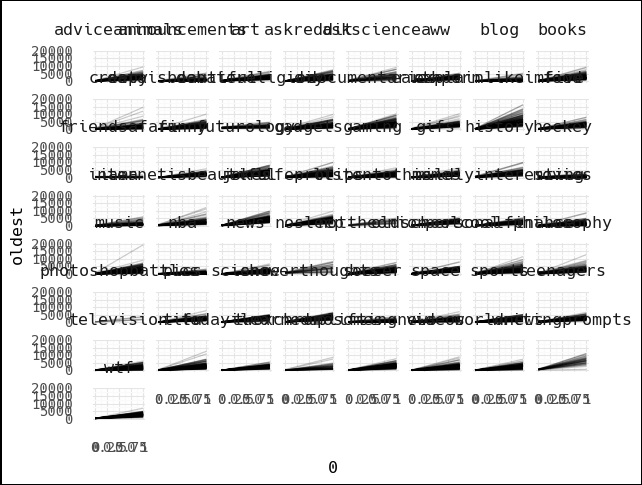

<ggplot: (8729182708658)>

In [63]:
#sub_order = df_agg.sort_values('dt_min_cmnt')['sub'].unique()
#df_agg['sub'] = pd.Categorical(df_agg['sub'], categories=sub_order)

p = ggplot(df_agg, aes(x=0, xend=1, y='oldest', yend='top10')) + geom_segment(size=0.5, alpha=0.2) + facet_wrap('~sub', ncol=8)
#p = p + scale_x_continuous(name='post order, nth')
p = p + theme_minimal() + theme(text = element_text(family='Hack', size=12),
                                axis_text = element_text(family='Hack', size=10),
                                plot_background=element_rect(fill='white'))
#p = p + scale_y_continuous(name='median score dominance')
p = p + theme(subplots_adjust={'wspace':0.2, 'hspace':0.5})
p.save('ratio-slop_by-sub.png', dpi=200, width=16, height=16)
p

In [2]:
p = ggplot(df.iloc[1:10000], aes(x='dt_min_cmnt/60')) + geom_density(aes(y='stat(scaled)')) + facet_wrap('~sort', ncol=2)
p = p + scale_x_continuous(name='time since submission, hours', breaks=[0, 6, 12, 18, 24])
p = p + theme_minimal() + theme(text = element_text(family='Hack', size=12),
                                axis_text = element_text(family='Hack', size=10),
                                plot_background=element_rect(fill='white'))
p = p + scale_y_continuous(name='density')
p = p + theme(subplots_adjust={'wspace':0.2})
p

NameError: name 'ggplot' is not defined

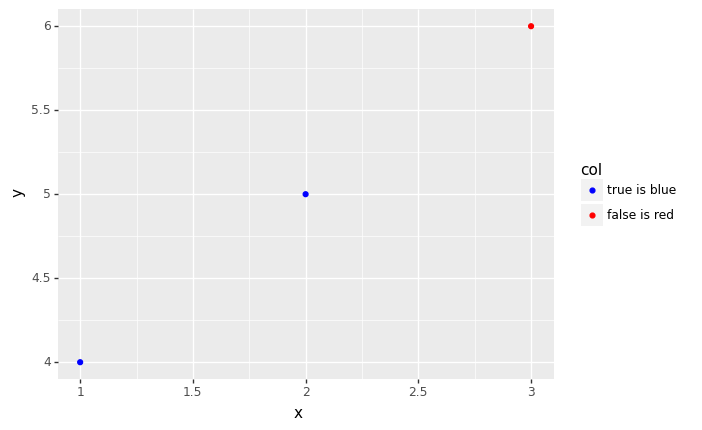

<ggplot: (8753429032147)>

In [68]:
tmp = pd.DataFrame({'x': [1, 2, 3],
                    'y': [4, 5, 6],
                    'col': [True, True, False]})

p = ggplot(tmp, aes(x='x', y='y', color='col')) + geom_point()
p = p + scale_color_manual(name='col',
                           limits=[True, False],
                           labels=['true is blue', 'false is red'],
                           values=['blue', 'red'])
p